# Feature: deconvolve beam pattern (`deconvolve`)

This notebook covers the development of a method to remove the beam-pattern effects that can be observed in DIDSON data.

## Dependencies

In [6]:
# utilities
import sys 
import os
sys.path.append(os.path.abspath("..")) 
from glob import glob 

import cv2 
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

# to get at test data
from skimage.io import imread 


## Point Spread Function

In [100]:
psf = np.array([0.06185567,  0. ,  0. ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.06185567,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.06185567,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.06958763,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.08247423,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.10309278,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.18041237,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.10309278,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.08247423,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.06958763,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.06185567,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.06185567,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0])
psf.shape = (1,len(psf))
print np.sum(psf) # should sum to 1 (so as not to add/remove energy from the image)

1.0


## Wiener deconvolution

In [96]:
def deconvolve(ping, psf, snr):
    ping = ping.astype(np.float64)
    
    # compute input ping's DFT
    img_f = cv2.dft(ping, flags = cv2.DFT_COMPLEX_OUTPUT) 
    psf/=psf.sum()
    psf_padded = np.zeros_like(ping)
    kh, kw = psf.shape
    psf_padded[:kh, :kw] = psf

    # compute (padded) psf's DFT
    psf_f = cv2.dft(psf_padded, flags=cv2.DFT_COMPLEX_OUTPUT, nonzeroRows = kh)

    psf_f_2 = (psf_f**2).sum(-1)
    ipsf_f = psf_f / (psf_f_2 + 1.0/snr)[..., np.newaxis]

    result_f = cv2.mulSpectrums(img_f, ipsf_f, 0)
    result = cv2.idft(result_f, flags = cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

    result = np.roll(result, -kh//2, 0)
    result = np.roll(result, -kw//2, 1)
    
    # renormalization
    result[result<0] = 0
    result*=(ping.max()+0.0)/result.max()
    
    return result.astype(ping.dtype)


In [88]:
def computeHist(ping):
    bins = np.arange(0,256)
    h = np.histogram(ping, bins)
    return (bins, (h[0]+0.0)/np.sum(h[0])) 

## Testing

11642


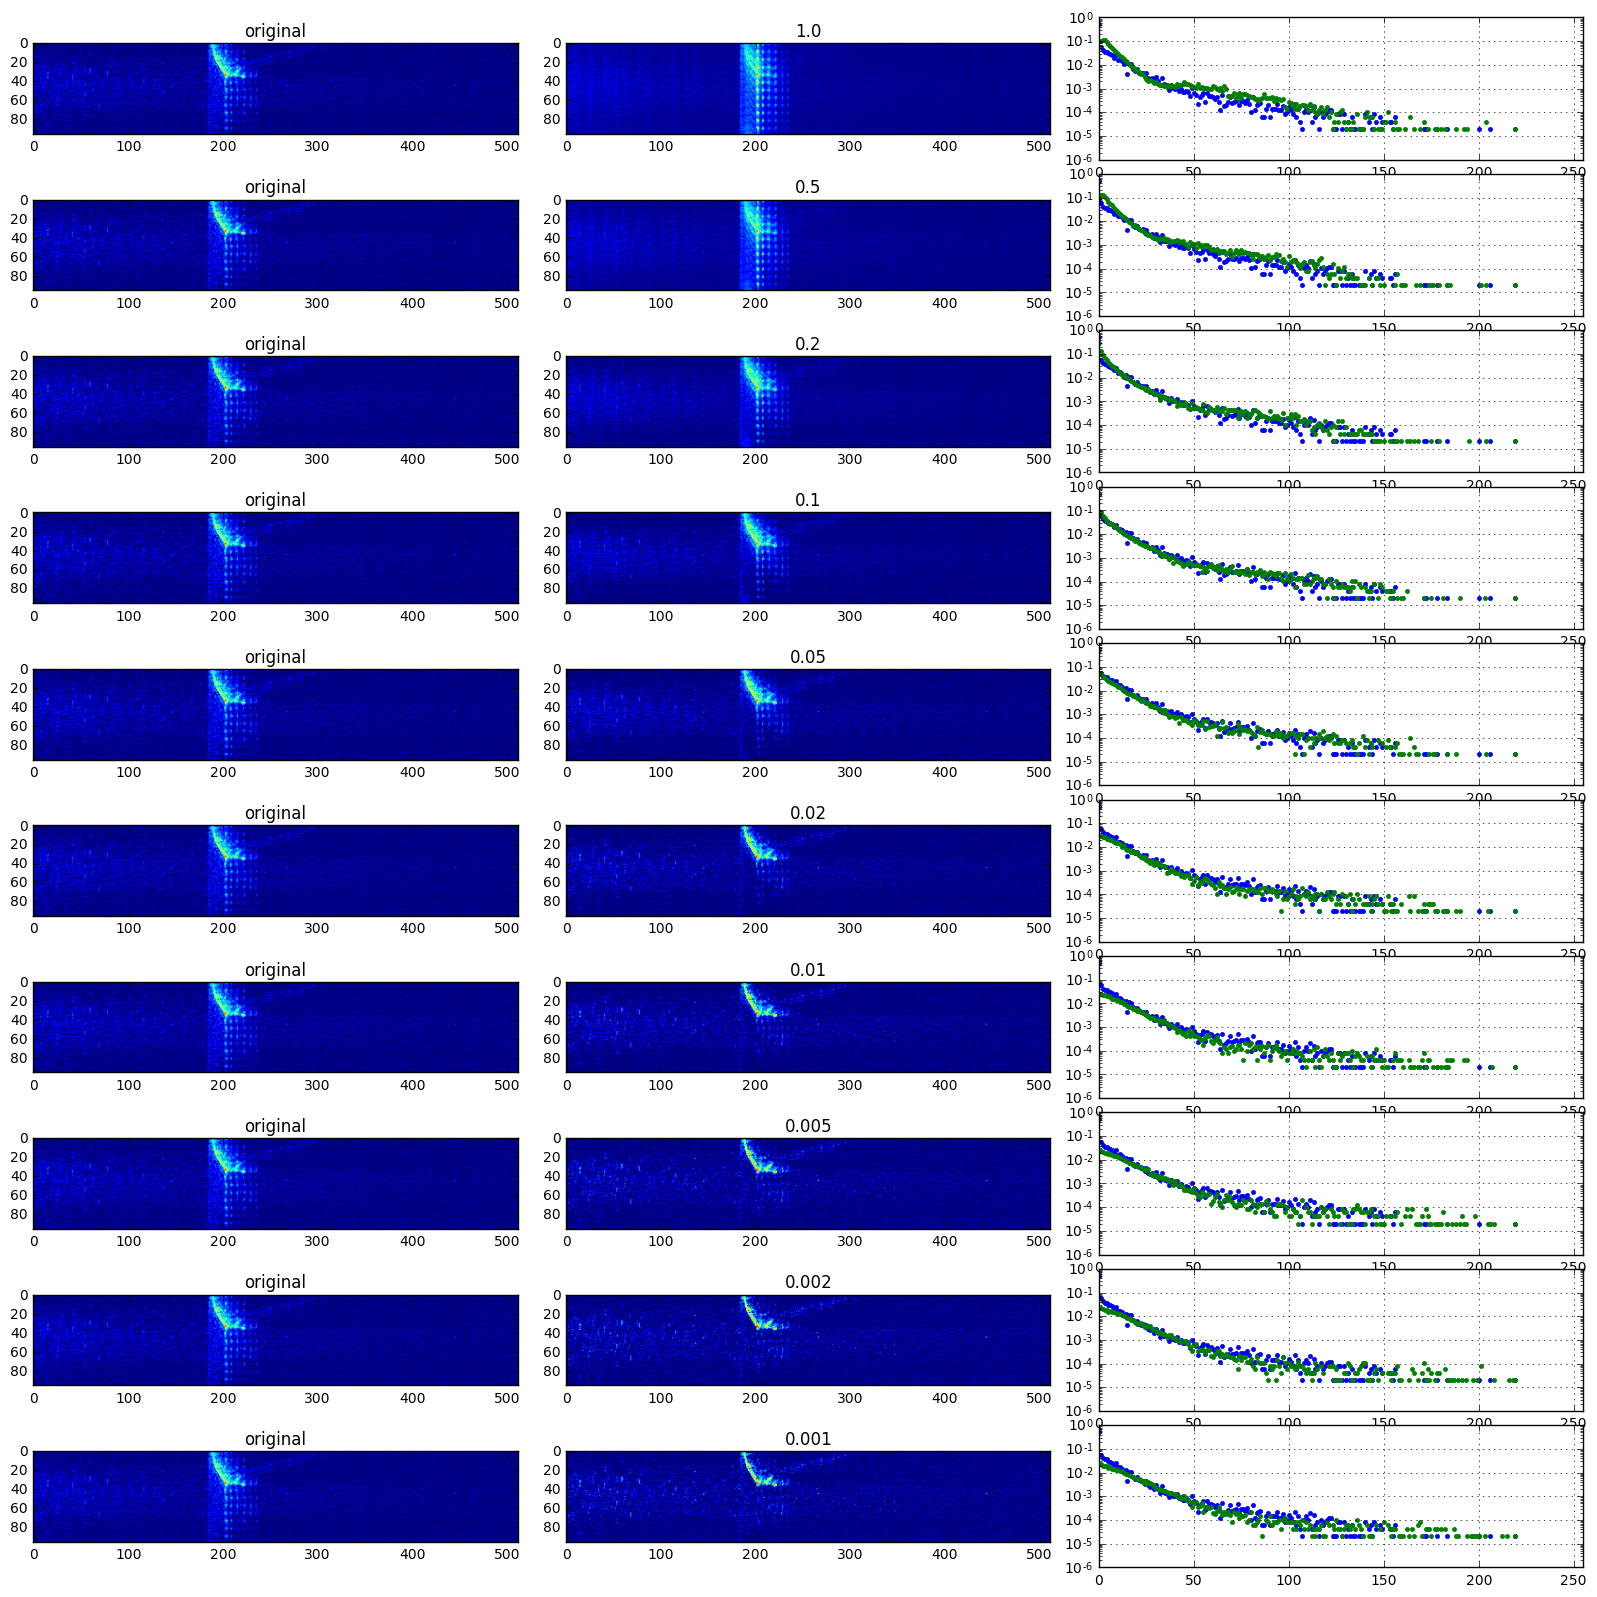

In [104]:
image_list = glob('/home/pvt/Workspace/rpl/project-hauv/2017-08-01.00_reprocess/pings/raw/*.png') 
idx = np.random.randint(0,len(image_list))
print idx
# idx = 13359
ping_raw = imread(image_list[idx], as_grey=True)

# snr = np.arange(1.0, 20.0, 2.0)
# snr = np.logspace(0.0, 3.0, num=10)
snr = [1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0 ]

plt.figure(figsize=(20,20))
colormap='jet'

for i in range(0,len(snr)):
#     print '1/snr:',1.0/snr[i]    
    ping_deconv = deconvolve(ping_raw,psf,snr[i])
    plt.subplot(len(snr),3,3*i+1)
    plt.imshow(ping_raw.transpose(),vmin=0,vmax=255,cmap=colormap)
    plt.title('original')
    plt.subplot(len(snr),3,3*i+2)
    plt.imshow(ping_deconv.transpose(),vmin=0,vmax=255,cmap=colormap)
    plt.title(1.0/snr[i])
    plt.subplot(len(snr),3,3*i+3)
    (b,hr) = computeHist(ping_raw)
    (b,hd) = computeHist(ping_deconv)
    plt.plot(b[:-1],hr,'.')
    plt.plot(b[:-1],hd,'.')
    plt.yscale('log')
    plt.grid()
    plt.xlim([0,255])
    plt.ylim([1e-6,1e0])
      
plt.subplots_adjust(hspace=0.1,wspace=0.1)
#plt.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01)

plt.show()